# Dependencies

In [19]:
%pip install ucimlrepo pandas seaborn matplotlib scikit-learn xgboost tensorflow scikeras

Note: you may need to restart the kernel to use updated packages.


## Helpers

In [45]:
import os

import numpy as np

import pandas as pd

import seaborn as sns

import joblib

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.svm import SVC

import xgboost as xgb

from ucimlrepo import fetch_ucirepo 

def GetDataset(Log = True):
    maternal_health_risk = fetch_ucirepo(id=863) 
    
    # Separar datos, (Pandas DataFrame)
    X = maternal_health_risk.data.features 
    Y = maternal_health_risk.data.targets 
    
    # Información básica del dataset
    if(Log):
        print("URL del repositorio: {}".format(maternal_health_risk.metadata['repository_url']))
        print("Descripción del dataset: {}".format(maternal_health_risk.metadata['abstract']))

        # Información de las variables
        display(maternal_health_risk.variables)

    return X, Y

def GetOutliers(X, BottomIrqCoef=1.5, TopIrqCoef=1.5):
    # Calculate Q1 and Q3 for all columns
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)

    # Calculate IQR for each column
    IQR = Q3 - Q1

    # Identify outliers
    outliers = (X < (Q1 - BottomIrqCoef * IQR)) | (X > (Q3 + TopIrqCoef * IQR))
    return outliers

def OutlierHandler(X, BottomIRQCoef, TopIRQCoef):
    # Crear una copia del dataset para no modificar el original
    X_copy = X.copy()
    
    # Obtener los outliers del dataset
    outliers = GetOutliers(X_copy, BottomIRQCoef, TopIRQCoef)

    for col in X.columns:
        if outliers[col].any():  # Check if there are outliers
            # Calculate the mean for the column
            mean_value = X[col].mean()

            # Check the dtype of the column and cast mean accordingly
            if pd.api.types.is_integer_dtype(X[col]):
                # Cast the mean to int if the column has integer dtype
                X_copy.loc[outliers[col], col] = int(mean_value)
            else:
                # If the column is of float type, assign the mean without casting
                X_copy.loc[outliers[col], col] = mean_value

    return X_copy

def DynamicOutlierHandler(X):
    X_copy = X.copy()
    best_coefs = {}

    # Iterate through each column to dynamically set the coefficients
    for col in X.columns:
        min_outliers = X[col].shape[0]
        best_bottom_coef = 1.5
        best_top_coef = 1.5

        # Test different coefficient values (from 1.0 to 3.0 in steps of 0.1)
        for bottom_coef in np.arange(1.0, 3.1, 0.1):
            for top_coef in np.arange(1.0, 3.1, 0.1):
                outliers = GetOutliers(X[[col]], bottom_coef, top_coef)
                num_outliers = outliers[col].sum()

                # Check if fewer outliers are found with current coefficients
                if num_outliers < min_outliers:
                    min_outliers = num_outliers
                    best_bottom_coef = bottom_coef
                    best_top_coef = top_coef

        # Save the best coefficients for this feature
        best_coefs[col] = (best_bottom_coef, best_top_coef)
        print(f"Best coefficients for {col}: Bottom={best_bottom_coef}, Top={best_top_coef}")

    # Use the best coefficients to handle outliers for each feature
    for col, (best_bottom_coef, best_top_coef) in best_coefs.items():
        outliers = GetOutliers(X[[col]], best_bottom_coef, best_top_coef)

        # Handle outliers by replacing with the mean (or other logic based on feature)
        if col in ['HeartRate', 'Age']:
            X_copy.loc[outliers[col], col] = int(X[col].mean())
        else:
            X_copy.loc[outliers[col], col] = X[col].mean()  # Replace with mean by default

    return X_copy

def ApplyTransformations(X):
    # Transformaciónes
    XT = pd.DataFrame()


    XT['Age'] = np.log(X['Age'] + 1)

    XT['SystolicBP'], _ = stats.yeojohnson(X['SystolicBP'])
    XT['DiastolicBP'], _ = stats.yeojohnson(X['DiastolicBP'])

    # Logarítmica para BS y BodyTemp
    XT['BS'] = np.log(X['BS'] + 1e-9)


    XT['BodyTemp'] = np.sqrt(X['BodyTemp'])


    # HeartRate no necesita transformación
    XT['HeartRate'] = X['HeartRate']

    return XT

def NormalizeData(X):
    """
    Normaliza los datos de un DataFrame usando MinMaxScaler.
    
    Args:
        X (pd.DataFrame): El DataFrame que contiene los datos a normalizar.

    Returns:
        pd.DataFrame: Un nuevo DataFrame con los datos normalizados.
    """
    normalizer = MinMaxScaler()
    normalized_data = pd.DataFrame(normalizer.fit_transform(X), columns=X.columns)
    return normalized_data

def preprocess_features(X):
    X_cleaned = DynamicOutlierHandler(X)
    X_transformed = ApplyTransformations(X_cleaned)
    X_normalized = NormalizeData(X_transformed)
    return X_normalized

def LabelEncoding(Y):
    # Codificar la variable target, debido a que las etiquetas son high risk, mid risk y low risk.
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y.values.ravel())

    return Y_encoded, label_encoder

def TrainTestSplit(X,Y,test_size = 0.2):    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X_train, X_test, Y_train, Y_test

def DatasetSummary(X, Y):
    """
    Función que une X (features) e Y (target), realiza los cálculos de outliers, skewness y kurtosis
    para las variables numéricas, y genera una tabla consolidada con esta información.

    Parámetros:
    X -- DataFrame con las variables independientes (features).
    Y -- Serie con la variable dependiente (target).
    
    Retorna:
    final_summary_df -- DataFrame con la información de las columnas unidas de X y Y,
                        incluyendo outliers, skewness y kurtosis para las variables numéricas.
    """
    # 1. Unir los datasets X y Y en uno solo (asumimos que Y es una Serie)
    combined_df = pd.concat([X, Y], axis=1)

    # 2. Filtrar solo las columnas numéricas de X para hacer los cálculos
    numeric_columns = X.select_dtypes(include=[np.number]).columns

    # 3. Calcular Q1 y Q3 para las columnas numéricas
    Q1 = X[numeric_columns].quantile(0.25)
    Q3 = X[numeric_columns].quantile(0.75)

    # 4. Calcular el IQR para las columnas numéricas
    IQR = Q3 - Q1

    # 5. Identificar outliers solo en las columnas numéricas
    outliers = (X[numeric_columns] < (Q1 - 1.5 * IQR)) | (X[numeric_columns] > (Q3 + 1.5 * IQR))

    # 6. Contar cuántos outliers existen en cada columna numérica
    outliers_count = outliers.sum()

    # 7. Calcular skewness y kurtosis solo para las columnas numéricas
    skewness = X[numeric_columns].skew()
    kurtosis = X[numeric_columns].kurt()

    # 8. Crear un DataFrame con la información general de las columnas
    info_df = pd.DataFrame({
        'Column': combined_df.columns,
        'Non-Null Count': combined_df.notnull().sum().values,
        'Dtype': combined_df.dtypes.values
    })

    # 9. Crear un DataFrame con los cálculos (outliers, skewness y kurtosis)
    summary_df = pd.DataFrame({
        'Outliers': outliers_count,
        'Skewness': skewness,
        'Kurtosis': kurtosis
    })

    # 10. Unir la información general con los cálculos
    final_summary_df = pd.concat([info_df.set_index('Column'), summary_df], axis=1).reset_index()

    # 11. Llenar NaN para las columnas no numéricas y target (Y) en los cálculos de skewness, kurtosis y outliers
    final_summary_df.fillna(value={"Outliers": np.nan, "Skewness": np.nan, "Kurtosis": np.nan}, inplace=True)

    display(final_summary_df)

def DatasetVisualization(X, Y, title="Dataset Overview"):
    num_features = len(X.columns)  # Número de características
    
    # Crear una figura grande
    fig = plt.figure(figsize=(18, 12))
    
    # Añadir un título general al dashboard
    fig.suptitle(title, fontsize=20, y=1.02)  # `y` ajusta la posición vertical del título

    # Crear una cuadrícula con 3 filas y num_features columnas
    gs = gridspec.GridSpec(3, num_features, height_ratios=[1, 1, 2], width_ratios=[1] * 6)

    # Subgráficos para los histogramas en la parte superior
    for i, col in enumerate(X.columns):
        ax_hist = plt.subplot(gs[0, i])
        sns.histplot(X[col], ax=ax_hist, kde=False, bins=10, color='skyblue', edgecolor='black')

    # Subgráficos para las curvas de densidad (KDE) en la segunda fila    
    for i, col in enumerate(X.columns):
        ax_kde = plt.subplot(gs[1, i])
        sns.kdeplot(X[col], ax=ax_kde, color='skyblue')  # Solo la línea de densidad

    # Subgráfico para los boxplots en la tercera fila, ocupando dos columnas
    ax_boxplots = plt.subplot(gs[2, :2])
    X.plot(kind='box', ax=ax_boxplots, subplots=False, patch_artist=True, grid=True, color='skyblue')
    ax_boxplots.set_title("Features", fontsize=16)

    # Subgráfico para la matriz de correlación, ocupando dos columnas (columnas 2 y 3 de la tercera fila)
    ax_corr = plt.subplot(gs[2, 2:4])
    corr_matrix = X.corr()
    sns.heatmap(corr_matrix, annot=True, ax=ax_corr, cmap='coolwarm', cbar=True)
    ax_corr.set_title("Correlation Matrix", fontsize=16)
    
    # Rotar etiquetas de la matriz de correlación en el eje x
    ax_corr.set_xticklabels(ax_corr.get_xticklabels(), rotation=45, horizontalalignment='right')

    # Subgráfico para la exploración de las clases de la variable objetivo, ocupando las últimas dos columnas
    ax_labels = plt.subplot(gs[2, 4:])  # Ocupa desde la columna 4 hasta el final
    y_values = Y.value_counts()

    # Gráfico de barras para la variable objetivo
    y_values.plot(kind='bar', ax=ax_labels, color='skyblue')
    ax_labels.set_title("Labels", fontsize=16)
    ax_labels.set_xlabel("Clase")
    ax_labels.set_ylabel("Frecuencia")
    ax_labels.set_xticklabels(ax_labels.get_xticklabels(), rotation=0)

    # Añadir etiquetas encima de las barras
    for p in ax_labels.patches:
        ax_labels.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.01))

    # Ajustar los gráficos
    plt.tight_layout()
    plt.show()

cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def create_cnn_model(input_shape, dropout_rate=0.5):
    """
    Crear un modelo CNN básico.
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))  # Adjust output layer for number of classes

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def KNN_Train(X, Y, n_neighbors=[5, 10, 20], weights=['uniform', 'distance'], Distance=[1, 2], cv=cv_folds):
    """
    Función para entrenar un modelo K-Nearest Neighbors (KNN) utilizando búsqueda de hiperparámetros
    con GridSearchCV y cross-validation.
    """
    param_grid_KNN = {
        'n_neighbors': [5, 10, 15, 20, 25, 30],
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
        'leaf_size': [20, 30, 40, 50]
    }


    # Realizar búsqueda de hiperparámetros usando GridSearchCV con cross-validation
    grid_search = GridSearchCV(estimator=KNeighborsClassifier(),
                               param_grid=param_grid_KNN,
                               scoring='f1_weighted',
                               cv=cv,  # Apply cross-validation here
                               verbose=0,
                               n_jobs=-1)

    # Ajustar el modelo con los datos de entrenamiento
    grid_search.fit(X, Y)

    # Obtener los mejores hiperparámetros encontrados
    best_knn_model = grid_search.best_estimator_

    return best_knn_model

def RF_Train(X, Y, class_weight, n_estimators=[5, 10, 20, 50], max_depth=[3, 5, 10],
             min_samples_split=[3, 5, 10, 20], min_samples_leaf=[1, 2, 4], 
             bootstrap=[True, False], cv=cv_folds):
    """
    Función para entrenar un modelo Random Forest utilizando búsqueda de hiperparámetros con GridSearchCV 
    y cross-validation.
    """
    param_grid_rf = {
        'n_estimators': [50, 100, 200, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    # Realizar búsqueda de hiperparámetros usando GridSearchCV con cross-validation
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight=class_weight),
                               param_grid=param_grid_rf,
                               scoring='f1_weighted',
                               cv=cv,  # Apply cross-validation here
                               verbose=0,
                               n_jobs=-1)

    # Ajustar el modelo con los datos de entrenamiento
    grid_search.fit(X, Y)

    # Obtener los mejores hiperparámetros encontrados
    best_rf_model = grid_search.best_estimator_

    return best_rf_model

def SVM_Train(X, Y, C_values=[0.1, 1, 10], kernels=['linear', 'rbf'], gammas=['scale', 'auto'], cv=cv_folds):
    """
    Entrenar un modelo SVM utilizando búsqueda de hiperparámetros con GridSearchCV.
    """
    param_grid = {
        'C': C_values,                # Regularization parameter
        'kernel': kernels,            # Kernel type
        'gamma': gammas               # Kernel coefficient
    }

    # Realizar búsqueda de hiperparámetros usando GridSearchCV
    grid_search = GridSearchCV(estimator=SVC(),
                               param_grid=param_grid,
                               scoring='f1_weighted',
                               cv=cv,  # Cross-validation
                               verbose=0,
                               n_jobs=-1)

    # Ajustar el modelo con los datos de entrenamiento
    grid_search.fit(X, Y)

    # Obtener los mejores hiperparámetros encontrados
    best_svm_model = grid_search.best_estimator_

    return best_svm_model

def XGB_Train(X, Y, learning_rates=[0.01, 0.1, 0.2], n_estimators=[50, 100, 200], max_depths=[3, 5, 7], cv=cv_folds):
    """
    Entrenar un modelo XGBoost utilizando búsqueda de hiperparámetros con GridSearchCV.
    """
    param_grid = {
        'learning_rate': learning_rates,
        'n_estimators': n_estimators,
        'max_depth': max_depths
    }

    # Realizar búsqueda de hiperparámetros usando GridSearchCV
    grid_search = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0),
                                param_grid=param_grid,
                                scoring='f1_weighted',
                                cv=cv,
                                verbose=0,
                                n_jobs=-1)

    # Ajustar el modelo con los datos de entrenamiento
    grid_search.fit(X, Y)

    # Obtener los mejores hiperparámetros encontrados
    best_xgb_model = grid_search.best_estimator_

    return best_xgb_model

def train_and_save_rf_model(X_train, Y_train, label, dir):
    # Usar 'balanced' para manejar el desbalanceo de clases automáticamente
    class_weight = 'balanced'

    # Entrenar el Modelo Random Forest
    RF_Model = RF_Train(X_train, Y_train, class_weight)  # Pasar class_weight

    # Crear el directorio si no existe
    os.makedirs(dir, exist_ok=True)

    # Guardar el modelo entrenado en el directorio especificado
    model_filename = os.path.join(dir, f"rf_model_{label}.pkl")
    joblib.dump(RF_Model, model_filename)

    print(f"Modelo Random Forest guardado exitosamente como {model_filename}.")
    return RF_Model

def train_and_save_knn_model(X_train, Y_train, label, dir):
    # Entrenar el Modelo KNN
    KNN_Model = KNN_Train(X_train, Y_train)

    # Crear el directorio si no existe
    os.makedirs(dir, exist_ok=True)

    # Guardar el modelo entrenado en el directorio especificado
    model_filename = os.path.join(dir, f"knn_model_{label}.pkl")
    joblib.dump(KNN_Model, model_filename)

    print(f"Modelo KNN guardado exitosamente como {model_filename}.")
    return KNN_Model

def train_and_save_svm_model(X_train, Y_train, label, dir):
    # Entrenar el modelo SVM
    SVM_Model = SVM_Train(X_train, Y_train)  # Llamar a la función de entrenamiento

    # Crear el directorio si no existe
    os.makedirs(dir, exist_ok=True)

    # Guardar el modelo entrenado en el directorio especificado
    model_filename = os.path.join(dir, f"svm_model_{label}.pkl")
    joblib.dump(SVM_Model, model_filename)

    print(f"Modelo SVM guardado exitosamente como {model_filename}.")
    return SVM_Model

def train_and_save_xgb_model(X_train, Y_train, label, dir):
    # Entrenar el modelo XGBoost
    XGB_Model = XGB_Train(X_train, Y_train)  # Llamar a la función de entrenamiento

    # Crear el directorio si no existe
    os.makedirs(dir, exist_ok=True)

    # Guardar el modelo entrenado en el directorio especificado
    model_filename = os.path.join(dir, f"xgb_model_{label}.pkl")
    joblib.dump(XGB_Model, model_filename)

    print(f"Modelo XGBoost guardado exitosamente como {model_filename}.")
    return XGB_Model

def process_and_train_models(X, Y, label_encoder, version_label, dir, cv=5):
    """
    Entrena los modelos KNN, Random Forest, SVM y XGBoost con validación cruzada (cross-validation),
    evalúa su rendimiento, y selecciona el mejor modelo basándose en la precisión de la clase 'high risk'.
    
    Parámetros:
    -----------
    X : array-like
        Datos de entrada (características).
        
    Y : array-like
        Etiquetas correspondientes a los datos de entrada.
        
    label_encoder : LabelEncoder
        El codificador de etiquetas (para decodificar predicciones).
        
    version_label : str
        Versión del modelo para guardar los modelos y el encoder.
        
    dir : str
        Directorio donde se guardarán los modelos y archivos.
        
    cv : int, opcional
        Número de folds para la validación cruzada (valor por defecto es 5).
    """

    model_dir = os.path.join(dir, version_label)

    # Crear el directorio si no existe
    os.makedirs(model_dir, exist_ok=True)

    # Train and save KNN, Random Forest, SVM, and XGBoost models in the specified directory
    KNN_Model = train_and_save_knn_model(X, Y, version_label, model_dir)
    RF_Model = train_and_save_rf_model(X, Y, version_label, model_dir)
    SVM_Model = train_and_save_svm_model(X, Y, version_label, model_dir)
    XGB_Model = train_and_save_xgb_model(X, Y, version_label, model_dir)

    # Save the label encoder in the specified directory
    encoder_filename = os.path.join(model_dir, f"label_encoder_{version_label}.pkl")
    joblib.dump(label_encoder, encoder_filename)
    print(f"LabelEncoder guardado como {encoder_filename}.")

    # Dictionary to store precision for high-risk class for each model
    model_performance = {}

    # Model Names and Objects for Retrieval
    models = {
        "KNN": KNN_Model,
        "Random Forest": RF_Model,
        "SVM": SVM_Model,
        "XGBoost": XGB_Model
    }

    # Perform evaluations and collect results using cross-validation
    for model_name, model in models.items():
        print(f"Evaluando {model_name} con {cv}-fold cross-validation...")
        
        # Cross-validation prediction
        y_pred_cv = cross_val_predict(model, X, Y, cv=cv)
        
        # Generate classification report
        report = classification_report(Y, y_pred_cv, target_names=label_encoder.classes_, output_dict=True)
        
        # Extract the precision for the high-risk class
        high_risk_precision = report['high risk']['precision']
        high_risk_f1 = report['high risk']['f1-score']
        
        # Store the precision for high-risk class
        model_performance[model_name] = {
            'precision': high_risk_precision,
            'f1': high_risk_f1,
            'report': report  # store the whole report for later printing
        }
    
    # Choose the best model based on the precision of the high-risk class
    best_model_name = max(model_performance, key=lambda x: model_performance[x]['precision'])
    best_model_report = model_performance[best_model_name]['report']
    
    print(f"\nMejor modelo basado en precisión para 'high risk': {best_model_name}")
    print("Reporte de clasificación del mejor modelo:")
    print(classification_report(Y, cross_val_predict(models[best_model_name], X, Y, cv=cv), target_names=label_encoder.classes_))

    # Save the best model comparison in the specified directory
    comparison_filename = os.path.join(model_dir, f"model_comparison_{version_label}.txt")
    with open(comparison_filename, "w") as file:
        file.write(f"Mejor modelo: {best_model_name} basado en la precisión para 'high risk'.\n")
        file.write(f"Precision: {model_performance[best_model_name]['precision']}\n")
        file.write(f"F1-Score: {model_performance[best_model_name]['f1']}\n")

    print(f"Información de comparación guardada como {comparison_filename}.")

def load_model(version_label, model_type="", dir="trainedModels/"):
    """
    Cargar el modelo entrenado basado en el version_label y el tipo de modelo especificado.
    
    Parámetros:
    -----------
    version_label : str
        El string que representa la versión de los modelos (ejemplo: "v1.2").
    
    model_type : str, opcional
        El tipo de modelo a cargar: "KNN", "Random Forest", "SVM", "XGBoost".
        Si está vacío, carga el mejor modelo basado en el archivo de comparación.
    
    dir : str, opcional
        Directorio donde están guardados los modelos (valor por defecto es "trainedModels/").
    
    Retorno:
    --------
    model : sklearn model
        El modelo entrenado (KNN, Random Forest, SVM, o XGBoost).
        
    label_encoder : LabelEncoder
        El label encoder asociado al modelo.
    """
    # Ensure the path contains the correct separator
    model_dir = os.path.join(dir, version_label)

    # Definir los nombres de los archivos de los modelos en el directorio
    knn_model_filename = os.path.join(model_dir, f"knn_model_{version_label}.pkl")
    rf_model_filename = os.path.join(model_dir, f"rf_model_{version_label}.pkl")
    svm_model_filename = os.path.join(model_dir, f"svm_model_{version_label}.pkl")
    xgb_model_filename = os.path.join(model_dir, f"xgb_model_{version_label}.pkl")
    label_encoder_filename = os.path.join(model_dir, f"label_encoder_{version_label}.pkl")
    comparison_filename = os.path.join(model_dir, f"model_comparison_{version_label}.txt")
    
    # Cargar el LabelEncoder
    label_encoder = joblib.load(label_encoder_filename)
    
    # Si model_type está vacío, cargar el modelo mejor basado en el archivo de comparación
    if model_type == "":
        try:
            with open(comparison_filename, "r") as file:
                lines = file.readlines()
                for line in lines:
                    if "Mejor modelo" in line:
                        # Extract model type and remove extra text (e.g., "basado en")
                        better_model = line.split(":")[-1].strip().split()[0]
                        model_type = better_model
                        print(f"El mejor modelo es: {model_type}")
                        break
        except FileNotFoundError:
            raise ValueError(f"No se encontró el archivo de comparación para la versión: {version_label}")
    
    # Cargar el modelo basado en el tipo especificado (KNN, Random Forest, SVM, XGBoost)
    if model_type == "KNN":
        model = joblib.load(knn_model_filename)
        print(f"Modelo KNN cargado desde {knn_model_filename}.")
    elif model_type == "Random Forest":
        model = joblib.load(rf_model_filename)
        print(f"Modelo Random Forest cargado desde {rf_model_filename}.")
    elif model_type == "SVM":
        model = joblib.load(svm_model_filename)
        print(f"Modelo SVM cargado desde {svm_model_filename}.")
    elif model_type == "XGBoost":
        model = joblib.load(xgb_model_filename)
        print(f"Modelo XGBoost cargado desde {xgb_model_filename}.")
    else:
        raise ValueError(f"Tipo de modelo no reconocido: {model_type}. Debe ser 'KNN', 'Random Forest', 'SVM' o 'XGBoost'.")
    
    return model, label_encoder

def test_and_evaluate_model(model, label_encoder, X_test, Y_test):
    """
    Function to test the model, decode predictions, and generate a classification report.
    """
    # Perform predictions
    y_pred = model.predict(X_test)

    # Decode predicted labels (if necessary)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)

    # Generate the classification report (using sklearn's function)
    report = classification_report(Y_test, y_pred, target_names=label_encoder.classes_)
    
    # Print the classification report
    print(report)
    
    return report


# Dataset Exploration

## Dataset Visual and Statistical Exploration

URL del repositorio: https://archive.ics.uci.edu/dataset/863/maternal+health+risk
Descripción del dataset: Data has been collected from different hospitals, community clinics, maternal health cares from the rural areas of Bangladesh through the IoT based risk monitoring system.


,name,role,type,demographic,description,units,missing_values
0,Age,Feature,Integer,Age,Any ages in years when a women during pregnant.,None,no
1,SystolicBP,Feature,Integer,None,"Upper value of Blood Pressure in mmHg, another...",None,no
2,DiastolicBP,Feature,Integer,None,"Lower value of Blood Pressure in mmHg, another...",None,no
3,BS,Feature,Integer,None,Blood glucose levels is in terms of a molar co...,mmol/L,no
4,BodyTemp,Feature,Integer,None,None,F,no
5,HeartRate,Feature,Integer,None,A normal resting heart rate,bpm,no
6,RiskLevel,Target,Categorical,None,Predicted Risk Intensity Level during pregnanc...,None,no


,index,Non-Null Count,Dtype,Outliers,Skewness,Kurtosis
0,Age,1014,int64,1.0,0.783063,-0.391414
1,SystolicBP,1014,int64,10.0,-0.251189,-0.613382
2,DiastolicBP,1014,int64,0.0,-0.048441,-0.948634
3,BS,1014,float64,210.0,1.868203,2.303174
4,BodyTemp,1014,float64,210.0,1.750988,1.451680
5,HeartRate,1014,int64,2.0,-1.043525,8.398871
6,RiskLevel,1014,object,NaN,NaN,NaN


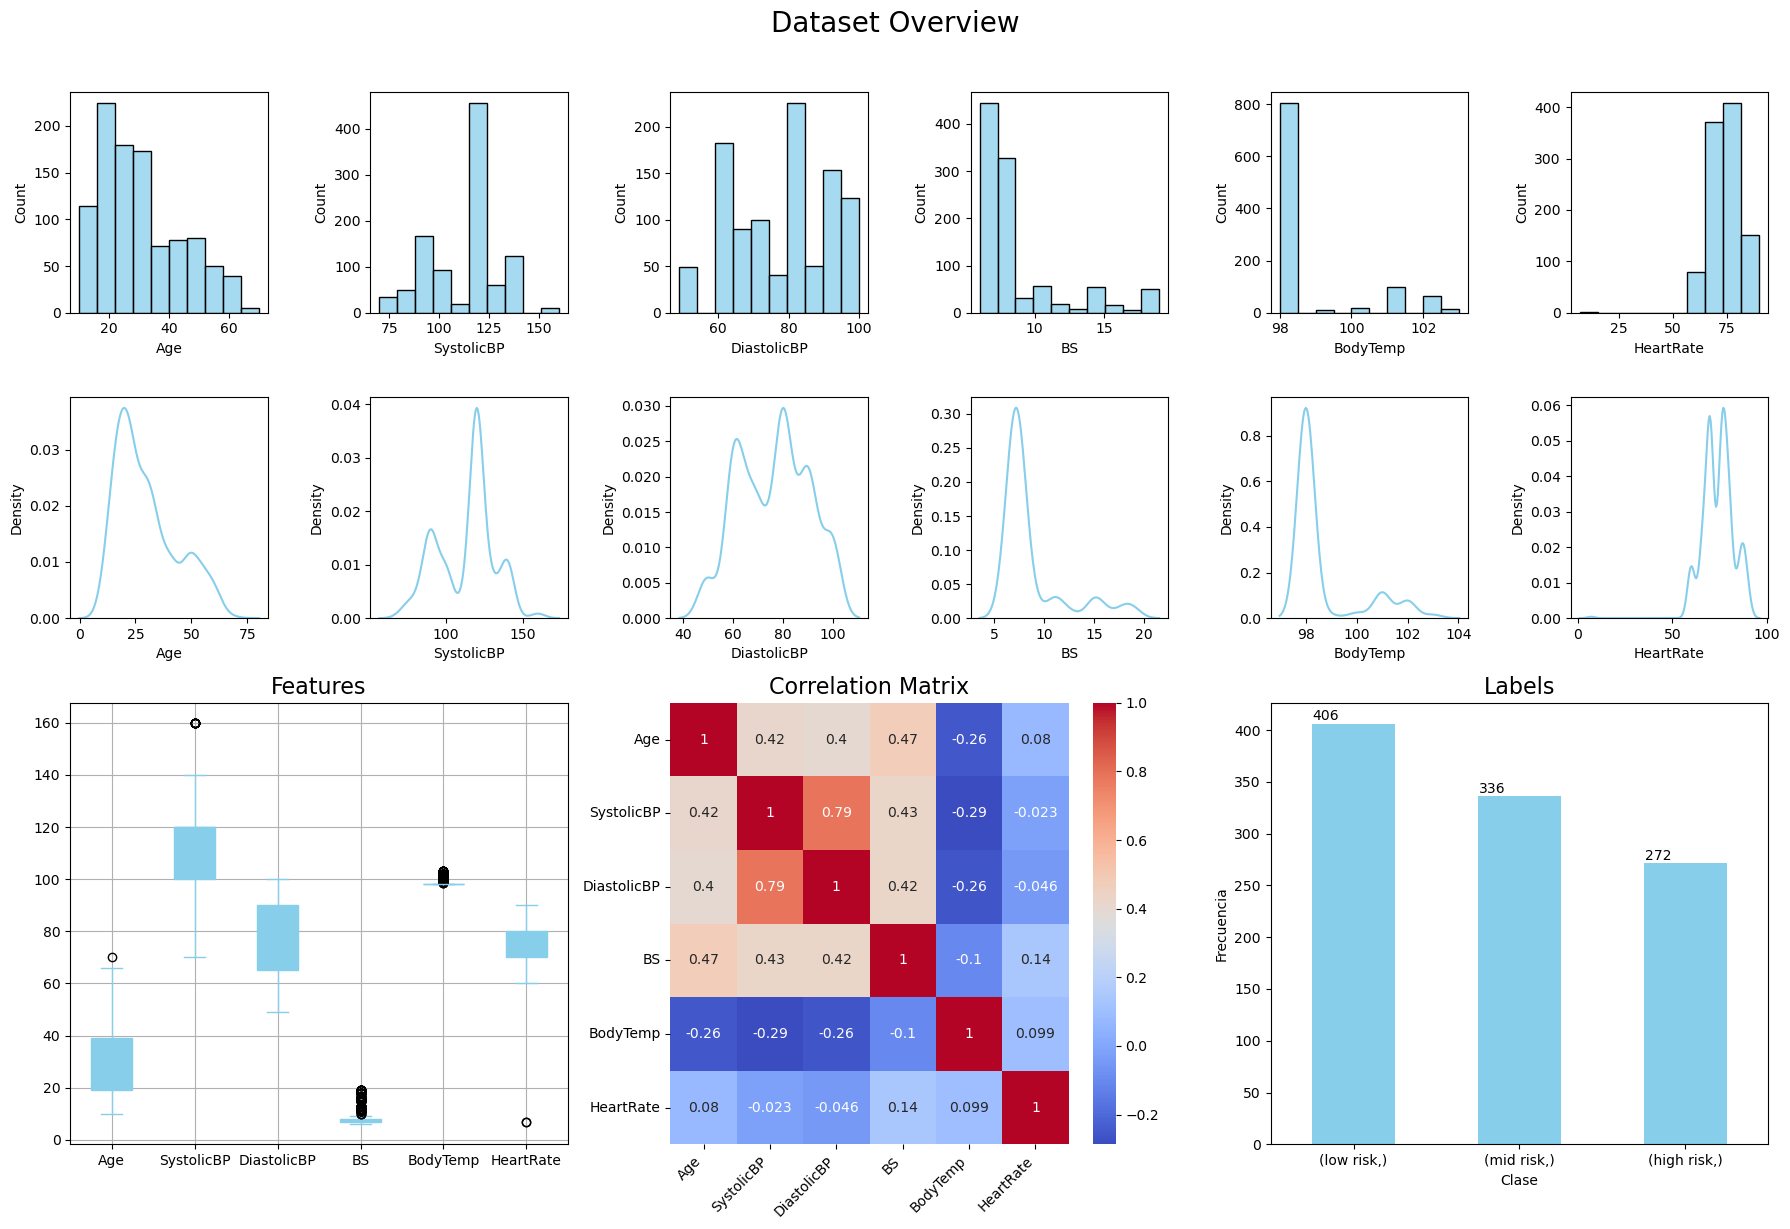

In [29]:
DatasetSummary(*GetDataset())
DatasetVisualization(*GetDataset(Log = False))

### Observaciones sobre las variables independientes:

1. El dataset cuenta con 6 columnas y 1014 registros, sin valores nulos.
2. Las 6 variables son numéricas, dos de ellas son de tipo `float64` (niveles de glucosa en sangre - BS y temperatura corporal - BodyTemp).

### Observaciones sobre la variable objetivo:

1. El dataset tiene una sola columna con 1014 registros, sin valores nulos.
2. La variable objetivo no es numérica.

### Desbalance en las clases de la variable objetivo:

El 27% de los datos corresponde a la clase "high risk", el 33% a "mid risk" y el 40% a "low risk". Para evitar el sesgo hacia la clase mayoritaria, se pueden aplicar varias técnicas:
1. Submuestreo de la clase mayoritaria (no aplicable debido al tamaño del dataset).
2. Sobremuestreo mediante SMOTE.
3. Ajustar los pesos del modelo, dándole más peso a la clase minoritaria durante el entrenamiento (opción seleccionada).

### Análisis estadístico y visual:

- **Age**: La mayoría de los datos se concentran entre 20 y 40 años, con algunos valores atípicos a los 70 años. El sesgo positivo es consistente con esta distribución.
- **SystolicBP**: Presenta un ligero sesgo negativo (-0.25), con una media de 113 y valores atípicos que alcanzan los 160.
- **DiastolicBP**: La media es 76, sin valores atípicos ni sesgo significativo (-0.048).
- **BS**: Se observan valores atípicos con un máximo de 19, mientras que la media es 8.72 y el sesgo positivo es elevado (1.87).
- **BodyTemp**: El valor máximo es 103 y la media 98, con un sesgo positivo (1.75).
- **HeartRate**: Se observa un sesgo negativo (-1.04) debido a un valor atípico de 7, que probablemente sea un error en los datos.

### Observaciones de la matriz de correlación:

- Existe alta correlación positiva entre DiastolicBP y SystolicBP (0.79).
- Tanto SystolicBP como DiastolicBP están correlacionados con la edad (0.42 y 0.4, respectivamente).
- BS también está positivamente correlacionado con SystolicBP y DiastolicBP (0.33 y 0.24), lo que sugiere que mayores niveles de glucosa están relacionados con una mayor presión arterial.
- BodyTemp y HeartRate no muestran relaciones relevantes con las demás variables.

### Imputación de Outliers

- Para el caso de Age, BS y Heart Rate, no se eliminaran los outliers, serán reemplazados por la media

### Transformaciones

- Para **alta asimetría positiva** (como en BS y BodyTemp): Considera usar una transformación logarítmica o de raíz cuadrada en lugar de la inversa.
- Para distribuciones **casi simétricas**(como en HeartRate): Es posible que no necesites aplicar ninguna transformación si la asimetría es cercana a cero.
- Para **ligera asimetría negativa** (como en SystolicBP): Considera usar transformaciones exponenciales o logarítmicas que podrían ayudar a normalizar la distribución.

## Transformations Visualization 

Best coefficients for Age: Bottom=1.0, Top=1.6000000000000005
Best coefficients for SystolicBP: Bottom=1.5000000000000004, Top=2.000000000000001
Best coefficients for DiastolicBP: Bottom=1.0, Top=1.0
Best coefficients for BS: Bottom=1.0, Top=2.8000000000000016
Best coefficients for BodyTemp: Bottom=1.0, Top=1.0
Best coefficients for HeartRate: Bottom=1.0, Top=1.0


/var/folders/mk/z3kghqmj3sn4lf01gl1tzy5h0000gn/T/ipykernel_44814/3317251095.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '113.19822485207101' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_copy.loc[outliers[col], col] = X[col].mean()  # Replace with mean by default
/var/folders/mk/z3kghqmj3sn4lf01gl1tzy5h0000gn/T/ipykernel_44814/3317251095.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '76.46055226824457' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_copy.loc[outliers[col], col] = X[col].mean()  # Replace with mean by default


,index,Non-Null Count,Dtype,Outliers,Skewness,Kurtosis
0,Age,1014,int64,1.0,0.783063,-0.391414
1,SystolicBP,1014,int64,10.0,-0.251189,-0.613382
2,DiastolicBP,1014,int64,0.0,-0.048441,-0.948634
3,BS,1014,float64,210.0,1.868203,2.303174
4,BodyTemp,1014,float64,210.0,1.750988,1.451680
5,HeartRate,1014,int64,2.0,-1.043525,8.398871
6,RiskLevel,1014,object,NaN,NaN,NaN


,index,Non-Null Count,Dtype,Outliers,Skewness,Kurtosis
0,Age,1014,float64,0.0,0.143480,-0.900695
1,SystolicBP,1014,float64,10.0,-0.061093,-0.516107
2,DiastolicBP,1014,float64,0.0,-0.057116,-0.945994
3,BS,1014,float64,56.0,0.860119,0.796112
4,BodyTemp,1014,float64,210.0,1.447745,0.096150
5,HeartRate,1014,float64,0.0,0.066856,-0.479515
6,RiskLevel,1014,object,NaN,NaN,NaN


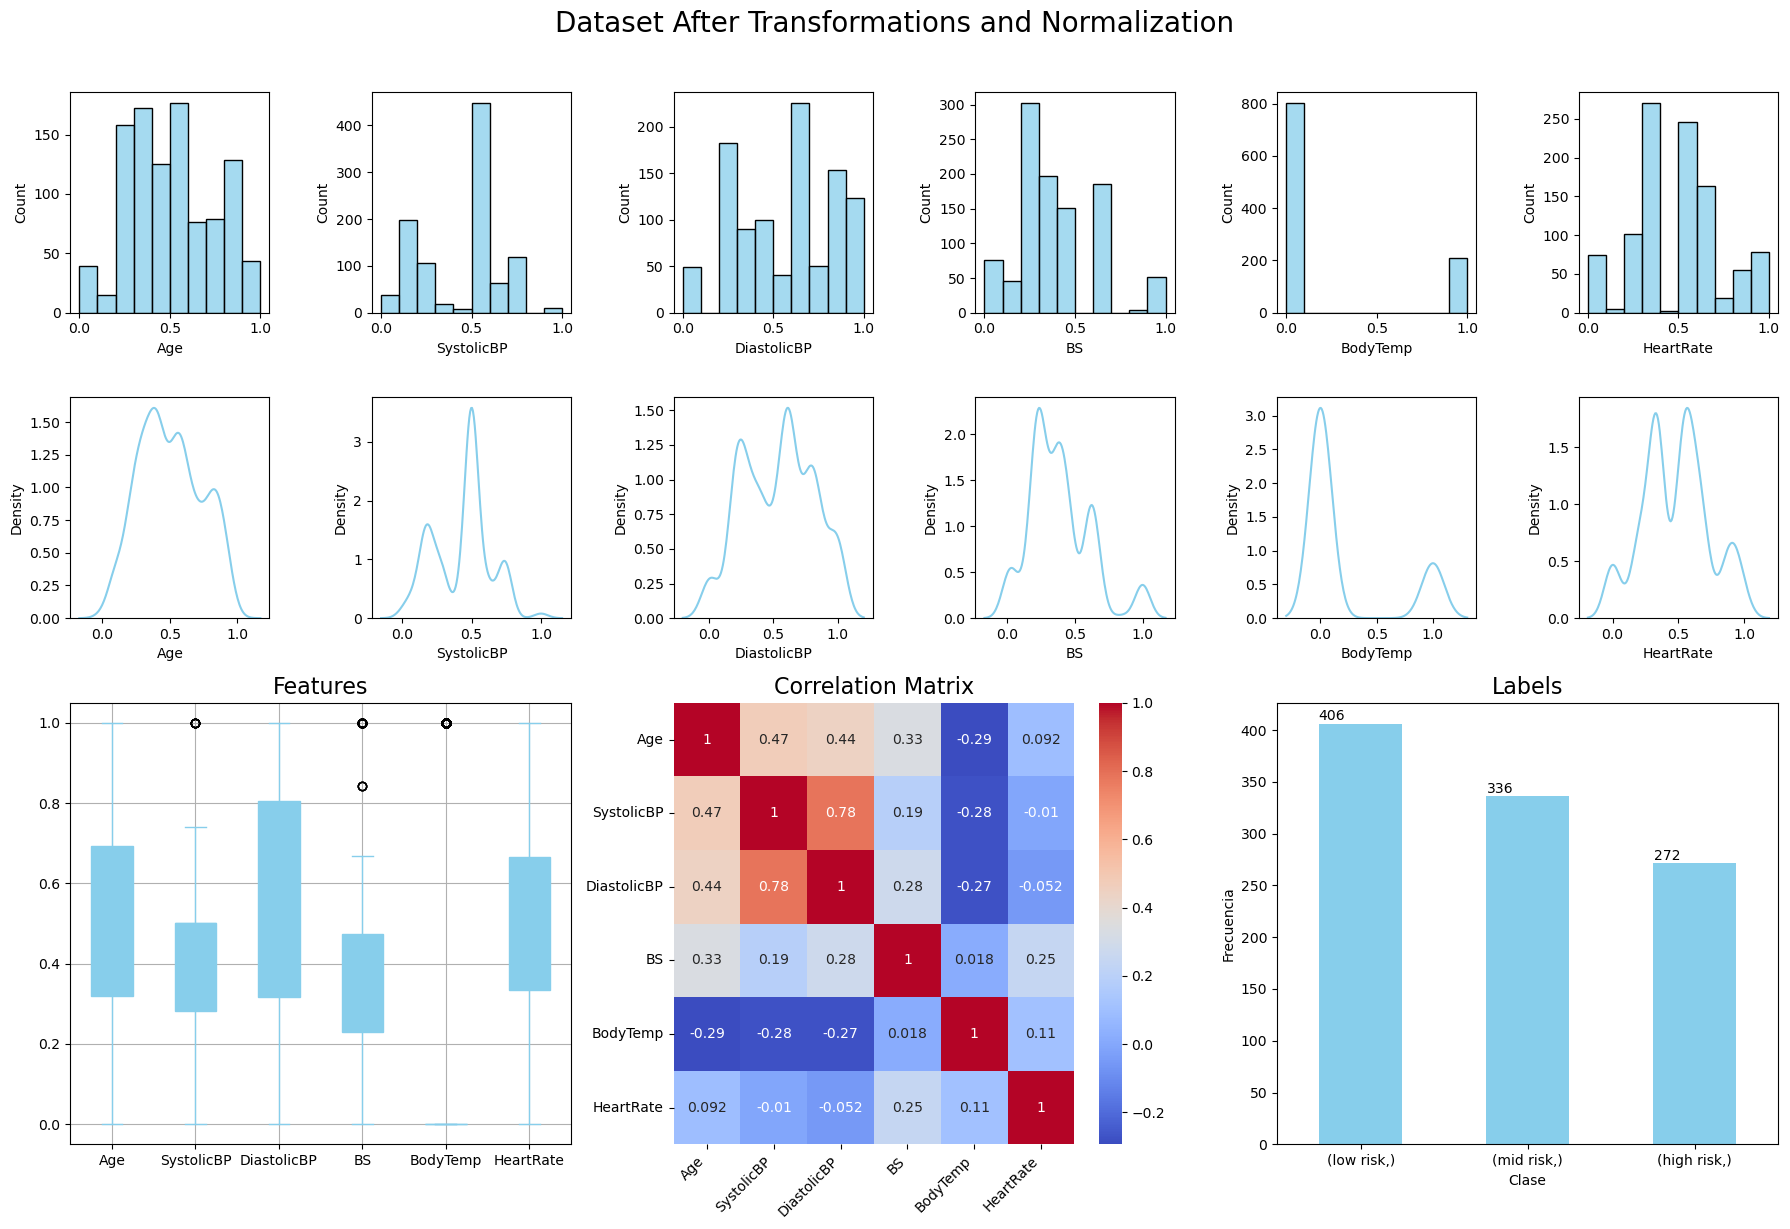

In [30]:
#Get Dataset Information
X,Y = GetDataset(Log=False)

# Features dataset preprocessing pipeline: Outlier Imputation -> Transformations -> Normalization
X = NormalizeData(ApplyTransformations(DynamicOutlierHandler(X)))

# Visualizar distribución de los datos
DatasetSummary(*GetDataset(Log=False))
DatasetSummary(X,Y)
DatasetVisualization(X, Y, title="Dataset After Transformations and Normalization")

## Model Training

In [46]:
# Label for versioning
version_label = "v0.1"

# Create the directory path for saving models
model_save_dir = "trainedModels/"

# Assuming you already have preprocessed data
# Obtener los datos
X, Y = GetDataset(Log=False)

# Features dataset preprocessing pipeline: Outlier Imputation -> Transformations -> Normalization
X = preprocess_features(X)

# Labels dataset preprocessing pipeline: Label Encoding
Y, label_encoder = LabelEncoding(Y)

# Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Now call the function and pass the train/test data, along with the save directory
process_and_train_models(X_train, Y_train, label_encoder, version_label, model_save_dir)

# Load the model and label encoder from the saved directory
model, label_encoder = load_model(version_label, model_type="", dir=model_save_dir)

# Test the model and generate the classification report
report = test_and_evaluate_model(model, label_encoder, X_test, Y_test)

# Mostrar los mejores parámetros y el reporte de clasificación
print("Mejores parámetros encontrados:", model)

Best coefficients for Age: Bottom=1.0, Top=1.6000000000000005
Best coefficients for SystolicBP: Bottom=1.5000000000000004, Top=2.000000000000001
Best coefficients for DiastolicBP: Bottom=1.0, Top=1.0
Best coefficients for BS: Bottom=1.0, Top=2.8000000000000016
Best coefficients for BodyTemp: Bottom=1.0, Top=1.0
Best coefficients for HeartRate: Bottom=1.0, Top=1.0


/var/folders/mk/z3kghqmj3sn4lf01gl1tzy5h0000gn/T/ipykernel_44814/2129549307.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '113.19822485207101' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_copy.loc[outliers[col], col] = X[col].mean()  # Replace with mean by default
/var/folders/mk/z3kghqmj3sn4lf01gl1tzy5h0000gn/T/ipykernel_44814/2129549307.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '76.46055226824457' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_copy.loc[outliers[col], col] = X[col].mean()  # Replace with mean by default


Modelo KNN guardado exitosamente como trainedModels/v0.1/knn_model_v0.1.pkl.
Modelo Random Forest guardado exitosamente como trainedModels/v0.1/rf_model_v0.1.pkl.
Modelo SVM guardado exitosamente como trainedModels/v0.1/svm_model_v0.1.pkl.
Modelo XGBoost guardado exitosamente como trainedModels/v0.1/xgb_model_v0.1.pkl.
LabelEncoder guardado como trainedModels/v0.1/label_encoder_v0.1.pkl.
Evaluando KNN con 5-fold cross-validation...
Evaluando Random Forest con 5-fold cross-validation...
Evaluando SVM con 5-fold cross-validation...
Evaluando XGBoost con 5-fold cross-validation...

Mejor modelo basado en precisión para 'high risk': KNN
Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

   high risk       0.88      0.83      0.85       225
    low risk       0.82      0.81      0.82       326
    mid risk       0.71      0.77      0.74       260

    accuracy                           0.80       811
   macro avg       0.80      0.80      0.80 

## Model Retrieval

In [47]:
# Define the version label and the directory where the models are stored
version_label = "v0.1"
model_save_dir = "trainedModels/"

# Load the model and label encoder from the specified directory
model, label_encoder = load_model(version_label, model_type="", dir=model_save_dir)

# Assuming X_test and Y_test are already defined in your pipeline
# Test the model and generate the classification report
report = test_and_evaluate_model(model, label_encoder, X_test, Y_test)

# Mostrar los mejores parámetros y el reporte de clasificación
print("Mejores parámetros encontrados:", model)

El mejor modelo es: KNN
Modelo KNN cargado desde trainedModels/v0.1/knn_model_v0.1.pkl.
              precision    recall  f1-score   support

   high risk       0.85      0.83      0.84        47
    low risk       0.83      0.78      0.80        80
    mid risk       0.76      0.82      0.78        76

    accuracy                           0.80       203
   macro avg       0.81      0.81      0.81       203
weighted avg       0.81      0.80      0.80       203

Mejores parámetros encontrados: KNeighborsClassifier(leaf_size=20, n_neighbors=20, p=1, weights='distance')
